  # Transfer Learning with Tensorflow Part 1: Feature Extraction 

  Transfer learning is levaraging a working model's Existing architecture and learned patterns .

  There are two main benefits:
  1. Can levarage an existing neural network architecture proven to work on problems similar to out own.
  2. If the similar pattern are learnt on the dataset that is similar to that of ours, then we can adapt those patterns to our owm data.

In [ ]:
!nvidia-smi

Wed Sep 22 01:08:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Download and becoming one wiht the data

In [ ]:
# get the 10 % data form the food classes from Food 101 

import zipfile 

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file 
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-09-22 01:08:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  66.9MB/s    in 2.4s    

2021-09-22 01:08:23 (66.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# how many images in each folder ?
import os

# Walk through 10 percent data directiory and list numer iof files 

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories in {dirpath} and {len(filenames)} images in it")

there are 2 directories in 10_food_classes_10_percent and 0 images in it
there are 10 directories in 10_food_classes_10_percent/train and 0 images in it
there are 0 directories in 10_food_classes_10_percent/train/ramen and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/chicken_curry and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/chicken_wings and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/ice_cream and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/grilled_salmon and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/steak and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/pizza and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/sushi and 75 images in it
there are 0 directories in 10_food_classes_10_percent/train/fried_rice and 75 images in it
there are 0 directories in 10_food_clas

### Creating the data loaders (preparing the data)

We will use the Image data Generator class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
#EPOCHS=5

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)


print("Training Images:")

train_data =train_datagen.flow_from_directory(train_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical')

print("Testing Images:")

test_data= test_datagen.flow_from_directory(test_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical')



Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks 

Callbacks are the extra fucntionality we can add to our models to be performed before and after training. Some of our most popular callbacks architecture

* Tracking experiments with Tensorboard callback 
* Model checkpoint with the ModelCheckpoint callback 
* Stopping the model form training ( to prevent overfitting)


In [ ]:
# Create the tensorboard callback

import datetime 

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard logfiles to :{log_dir}")
  return tensorboard_callback

### Creating models using tensorflowHUB 

In the past we have used tensorflow to create our models layer by layer from scratch 

Now we are going to do a similar process , except the majority of our mdoels layers are going to come from the tensorflowHub 

www.tfhub.dev

 Browsing the site and searching for image classification we found resnet50 to be better for the classification problem.

In [ ]:
# lets compare the following two models 

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 



In [ ]:
# Lets make a create_model() function to create a model from an URL 
def create_model(model_url, num_classes=10):
  
  """
  Takes a Tensorflow Hub url and creates a sequential model with it 
  Args :
  model url 
  num_classes
  
  returns:
  An uncompiled keras sequential model with model_url as feature extractor 
  
  """
   # Download the pre-trained model and save it as a keras layer
  
  feature_extractor_layer= hub.KerasLayer(model_url,trainable=False,name="feature_extraction_layer",input_shape=IMAGE_SHAPE+(3,))
  # Freeze the already learned patterns 
  # create our own model 
  model = tf.keras.Sequential([
                                feature_extractor_layer,
                                layers.Dense(num_classes,activation='softmax',name="output_layer")
   ]) 
  return model 




### Creating and testing resnet tensorflow model and testing 


In [ ]:
# create resnet model 

resnet_model= create_model (resnet_url,num_classes=train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our resnet model 

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])



In [ ]:
history_resnet=resnet_model.fit(train_data,
                            steps_per_epoch=len(train_data),
                            epochs=5,validation_data=test_data,validation_steps=len(test_data),callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name='resnet50v2')]
                            )


Saving Tensorboard logfiles to :tensorflow_hub/resnet50v2/20210922-012059
Epoch 1/5
24/24 [==============================] - 22s 948ms/step - loss: 0.3229 - accuracy: 0.9360 - val_loss: 0.6885 - val_accuracy: 0.7644
Epoch 2/5
24/24 [==============================] - 21s 900ms/step - loss: 0.2725 - accuracy: 0.9480 - val_loss: 0.6552 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - 21s 899ms/step - loss: 0.2301 - accuracy: 0.9667 - val_loss: 0.6507 - val_accuracy: 0.7784
Epoch 4/5
24/24 [==============================] - 21s 898ms/step - loss: 0.1968 - accuracy: 0.9680 - val_loss: 0.6455 - val_accuracy: 0.7852
Epoch 5/5
24/24 [==============================] - 21s 898ms/step - loss: 0.1676 - accuracy: 0.9787 - val_loss: 0.6363 - val_accuracy: 0.7900


the results outperform all the previous models that we trained on.

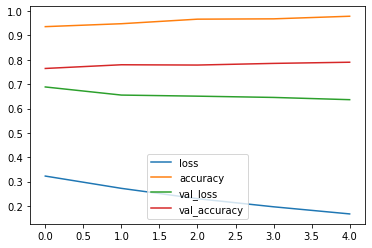

In [ ]:
import pandas as pd
pd.DataFrame(history_resnet.history).plot()

# Creating and Testign EfficeintNetB0 tensorflow hub feature extraction model 

In [ ]:
# create EfficientNet 
efficient_model =create_model(efficientnet_url,train_data.num_classes)

In [ ]:
efficient_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# Compile the efficient net model
efficient_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# Fit the efficient net model 
history_efficient=efficient_model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name='efficientnet')]) 

Saving Tensorboard logfiles to :tensorflow_hub/efficientnet/20210922-012300
Epoch 1/5
24/24 [==============================] - 31s 915ms/step - loss: 1.8321 - accuracy: 0.4307 - val_loss: 1.2663 - val_accuracy: 0.7444
Epoch 2/5
24/24 [==============================] - 18s 771ms/step - loss: 1.0489 - accuracy: 0.7800 - val_loss: 0.8519 - val_accuracy: 0.8288
Epoch 3/5
24/24 [==============================] - 18s 774ms/step - loss: 0.7500 - accuracy: 0.8427 - val_loss: 0.6886 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 18s 777ms/step - loss: 0.6025 - accuracy: 0.8627 - val_loss: 0.6030 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 18s 775ms/step - loss: 0.5091 - accuracy: 0.8853 - val_loss: 0.5481 - val_accuracy: 0.8684


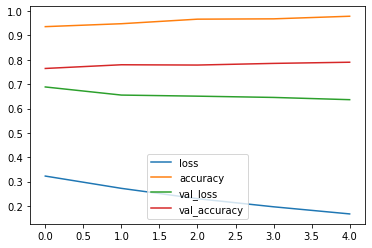

In [ ]:
import pandas as pd
pd.DataFrame(history_resnet.history).plot()

### Different Types of Transfer learning 

* **As is transfer** - Learning where we make no change to the existing transfer learning model 
* **Feature extraction**  - Use the per-learned patterns of an exisiting model.
* **Fine tuining transfer learning** - Use the prelearned patterns and fine tune them.


# Comparing our model results using TensorBoard

 When we upload the results the Tensorboard .dev , the experiments are public. 

In [ ]:
# upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/\
 --name "efficeint net vs resnet "\
 --description "comparing two different tf extraction model"\
 --one_shot  

2021-09-22 01:48:28.751548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 01:48:28.779557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-22 01:48:28.780085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac